# Point Source Neutrino Search Method Tester  
### 6-1-2021

This document serves to illustrate the usage of this package. Specifically it will run through the following: 
* Defining the objects created in this package
* Testing methods with sky maps/ TS creation  
* Creating background TS for methods included/ SLURM integration
* Signififance testing/ obtaining results 
* Data used/ introducing new event data
* Introducing a new method to the package
---

The following features are a WIP and will be added at a later date:
* Sensitivity calculation 
* Skylab integration/ direct comparisons 
* Merging background distributions into one object for tests
---

In [1]:
from package import * 

The package is based upon the creation of a "multi_tester" object. This object holds all methods you want to be using and from this object you can create background TS distribtuions and do significance tests directly between methods on the same events. 

Shown here is the creation of a multi_tester object that will be used to compare the classic likelihood and multi-map methods. This example will be used to show the rest of the package.

The 'methods' argument takes in a list of the _exact_ function names of the methods you wish to use. The 'tracks' and 'cascades' arguments define the number of each event topology to generate in each sky using MC IceCube data.

A multi_tester obejct takes in "args" which is a dictionary consisting of arguments used in varying methods. \

__Argument requirements:__
* LLH/ LLH Dependent Methods: delta_ang- LLH search band width 
* TCP/ TruePrior: Prior- 2D array indexed as [tracks, cascades] giving a topology-based LLH prior
* SMTopoAw: (Optional) Sigmoid: Tuple of sigmoid parameters (center, shape) 

In [2]:
tester = multi_tester(methods = ['LLH', 'MM'], tracks = 200, cascades = 70, args = {'delta_ang': .2})
print(tester)

Multi-tester object using the following methods: ['LLH', 'MM']
Background tracks: 200 Background Cascades: 70
            


## Testing the methods and creating skies 

Note: Any angle/declination specifications are inputted in **radians** (including dec. bands and delta_ang)

In [3]:
#creating background test statistics 
#creates a MC sky according to tracks, cascades and tests it at ra,dec
ra = np.pi/3
dec = np.pi/4

LLH_TS, MM_TS = tester.test_methods(ra, dec)
print(f"LLH: {LLH_TS} MM: {MM_TS}")

#creating signal test statistics 
#injects a ninj_t track ninj_c cascade source at ra, dec and calculates the TS 
ra = np.pi/3
dec = np.pi/4

LLH_TS, MM_TS = tester.test_methods(ra, dec, ninj_t = 2, ninj_c = 2)
print(f"LLH: {LLH_TS} MM: {MM_TS}")

LLH: 0.0 MM: 7.981223655645472e-168
LLH: 36.705602405860816 MM: 3.362813293487764


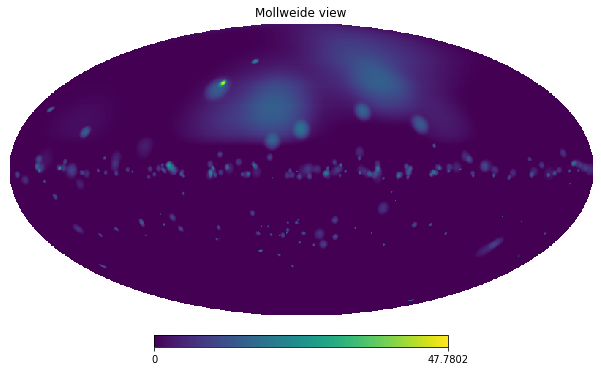

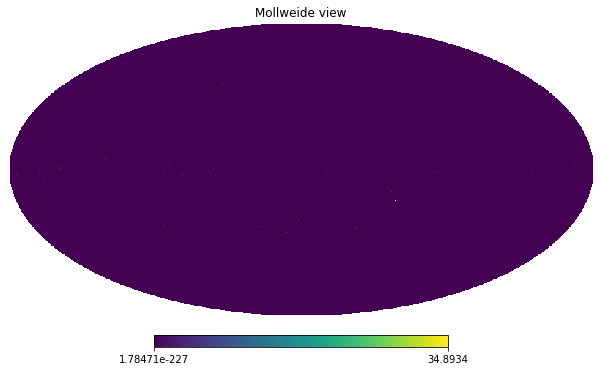

In [4]:
inj_ra = np.pi/3
inj_dec = np.pi/4
ninj_t = 3
ninj_c = 3

#creates a MC sky with an injection as specified above
#returns healpy array of TS at each point
tester.create_sky(ninj_t, ninj_c, inj_ra, inj_dec)
#sky can be shown with this method, either saved in plots or shown inline based on "inline"
tester.show_sky(inline = True)

## Background Distribution Creation

To accurately test methods against one another, one needs to calculate large numbers of background TS to find p-value of signal trials. This often is impractical to do on a single CPU and thus, the built in way to do this is through SLURM.

The directory ./templates has slurm job templates; __These need to be filled out manually for each user.__

The run() method takes in information about the number of trials you want to create and the number of jobs to split it into, as well as implementation for creating signal trials and getting p-values all at once in parallel through use of SLURM DAGs.

Once tester.run() is ran _on a SLURM computing cluster_, then jobs will immediatly be sent out to create the background trials. The files will temporarily be stored in ./working until all background trials are done. Then they will be repackaged and stored to ./data

If signal trials are specified two more files will ultimately be saved to ./data: SIGNAL (signal TS dist) and SIGMA (significances).

__Once ran, your multi_tester object is specified by its unique time tag created by the datetime package and can its name can be found in tester.name after running__ 

Your object will ultimately be saved out to ./Testers using pickle and can/should be later loaded in to use the created background distribution. 

In [14]:
trial_count = 2e6
file_count = 200 
time = '4:00:00'

#creates 2mill background trials split into 200 4hr jobs 
tester.run(trial_count, file_count, time)

#creates the same background as above, but also calculates 1000 signal trials with a 2,2 injection
#clean keyword clears the ./working directory after all data is packaged 
tester.run(trial_count, file_count, time ,clean = True, signal_trials = 1000, ninj_tracks = 2, ninj_cascades = 2)

print(tester.name)

multitester_20210601170348245229


## Significances and Method Results

Significances can be calculated inline with the creation of background TS through the process stated above.

In calculating source significances, sources are compared to other events within their declination band (which are explicitly defined in creation of a multi_tester object).\
The inline significance calculation and background TS creation pull uniformly from each declination bin, and so to reach 5sigma in each bin more than 2 million * bin_count signal trials are needed in the background creation.

---

To compute results manually after creation of the background distribution, you can load the following function to store the background data in tester.bkg

In [ ]:
tester.load_TS()
TS_distribution = tester.bkg['TS']
dec_distribution = tester.bkg['dec']

One can then manually compute significances through use of test_methods and calculate_sigma

In [33]:
TS = tester.test_methods(ra, dec, ninj_t = 2, ninj_c = 2)
tester.calculate_sigma(TS, dec)

One can furthermore create TC space, showing the percent of injections above 5sigma at varying topology ratios using the TC_space method.

In [ ]:
ntrials = 1000 
size = 10

#tests each topology ratio between 1 to 10 tracks and 1 to 10 cascades as sources 1000 times and logs percent above 5 sigma
#produces a 2D array; can be plotted if "plot" = True (saved to ./plots)
tester.TC_space(ntrials, dec, size, plot = False)

## Event Data

**Blurb about event data origin and gen() function calls** 

The underlying data used to generate events in this package comes from the ./mcdata/tracks_mc.npy and ./mcdata/cascade_mc.npy files. These files are in IceCube format as structured numpy arrays. \
One can change the data to pull from different samples simply by creating a new dataset for both topologies with appropriatly named columns, running them through data_format found in utils, and then placing the formatted npy files into mcdata. \
If your new data is IceCube formatted, running it through ./utils/data_format.py should fix any typeError problems with the data and make sure both files are identically formatted. 

## Implementing New Methods

It is important to note that you _can_ implement new methods into this package by placing the method definition into package.py, but the method must be formatted a certain way:

In [37]:
def Method(tracks, cascades, ra, dec, args):
    #how to correctly get overall events
    evs = np.concatenate([tracks, cascades])
    #how to correctly pass in needed arguments
    var = args['var']
    #return MUST be a tuple 
    return TS, etc